# Computing a model for DGEMM - testing different geometries

In [1]:
import io
import zipfile
import pandas
import warnings
import os
import yaml
import re
import plotnine
from plotnine import *
plotnine.options.figure_size = (12, 8)
warnings.simplefilter(action='ignore')
import cashew
print(cashew.__git_version__)
from cashew import archive_extraction as ae
from cashew import linear_regression as lr

directory = 'geometry/1/'
archives = [os.path.join(directory, f) for f in os.listdir(directory)]
archives

f6e1abe82ebba1eec668652189985c631c10b5b5


['geometry/1/grenoble_2020-07-08_1939567.zip',
 'geometry/1/grenoble_2020-07-08_1939568.zip',
 'geometry/1/grenoble_2020-07-08_1939569.zip']

In [2]:
dataframes = []
for archi in archives:
    df = ae.read_performance(archi)
    df['expfile'] = ae.read_yaml(archi, 'info.yaml')['expfile'][0]
    df['archive'] = archi
    df['start_time'] = pandas.to_datetime(df['start_time'], unit='s')
    dataframes.append(df)

df = pandas.concat(dataframes)
print(len(df))
df.head()

987040


,function,m,n,k,timestamp,duration,core,node,cluster,jobid,cpu,start_time,index,expfile_hash,expfile,archive
0,dgemm,17064,504,128,49.803671,0.077525,0,1,dahu,1939567,0,2020-07-08 06:25:34,0,7182bdc09785b7b57fa9065f096c0774467e68b7da37e9...,large_M.csv,geometry/1/grenoble_2020-07-08_1939567.zip
1,dgemm,22143,516,128,49.881221,0.102553,0,1,dahu,1939567,0,2020-07-08 06:25:34,1,7182bdc09785b7b57fa9065f096c0774467e68b7da37e9...,large_M.csv,geometry/1/grenoble_2020-07-08_1939567.zip
2,dgemm,64946,158,128,49.983781,0.104161,0,1,dahu,1939567,0,2020-07-08 06:25:34,2,7182bdc09785b7b57fa9065f096c0774467e68b7da37e9...,large_M.csv,geometry/1/grenoble_2020-07-08_1939567.zip
3,dgemm,14421,353,128,50.087950,0.046851,0,1,dahu,1939567,0,2020-07-08 06:25:34,3,7182bdc09785b7b57fa9065f096c0774467e68b7da37e9...,large_M.csv,geometry/1/grenoble_2020-07-08_1939567.zip
4,dgemm,71920,406,128,50.134808,0.271511,0,1,dahu,1939567,0,2020-07-08 06:25:34,4,7182bdc09785b7b57fa9065f096c0774467e68b7da37e9...,large_M.csv,geometry/1/grenoble_2020-07-08_1939567.zip


## Model with the merged data

It would be very nice to have a unified model and not three distinct models. Do we have something realistic enough if we compute the model with the whole dataset?

In [3]:
df_merged = df.copy()
df_merged['expfile_hash'] = 'foo'  # the regression function in cashew groups by jobid/expfile
df_merged['jobid'] = 42
df_merged['start_time'] = 42
reg_dict = lr.regression(df_merged, lr.compute_dgemm_reg)
reg = pandas.DataFrame(reg_dict)
assert len(reg) == len(df['node'].unique())*2  # sanity check, we should have one and only one model per CPU per node
reg.head()

,intercept,mnk,mn,mk,nk,tvalue_mnk,tvalue_mn,tvalue_mk,tvalue_nk,intercept_residual,...,tvalue_mk_residual,tvalue_nk_residual,avg_gflops,function,cluster,node,expfile_hash,cpu,jobid,start_time
0,0.000003,7.394729e-11,-2.445496e-10,4.252655e-10,2.239360e-09,88.255831,-2.274384,8.079294,42.543887,3.426729e-07,...,15.569654,15.927640,26.520823,dgemm,dahu,1,foo,0,42,42
1,0.000002,7.000482e-11,-2.785525e-10,3.394621e-10,2.001561e-09,81.614966,-2.530606,6.299778,37.145203,4.284178e-07,...,15.596843,11.675681,28.233271,dgemm,dahu,1,foo,1,42,42
2,0.000003,7.299057e-11,-2.658263e-10,5.351639e-10,2.331181e-09,94.063410,-2.669485,10.978246,47.821390,4.405208e-07,...,17.415308,16.654968,26.845210,dgemm,dahu,2,foo,0,42,42
3,0.000003,6.941351e-11,-2.612029e-10,4.776279e-10,2.098164e-09,85.850850,-2.517411,9.403346,41.307804,5.304273e-07,...,14.004688,13.252692,28.313150,dgemm,dahu,2,foo,1,42,42
4,0.000003,7.140143e-11,-2.004919e-10,8.924510e-10,2.278175e-09,99.441623,-2.175874,19.785079,50.505700,3.701914e-07,...,6.037312,28.701277,27.121179,dgemm,dahu,3,foo,0,42,42


In [4]:
import numpy

def compute_pred(df, reg, melt=True):
    numpy.random.seed(42)
    df = df.copy().reset_index(drop=True)
    lr.compute_variable_products(df, 'mnk')
    df['raw_pred'] = 0
    df['noise_sigma'] = 0
    for _, (node, cpu) in df[['node', 'cpu']].drop_duplicates().iterrows():
        model = reg[(reg['node'] == node) & (reg['cpu'] == cpu)]
        assert len(model) == 1
        model = model.iloc[0]
        mask = (df['node'] == node) & (df['cpu'] == cpu)
        df.loc[mask, 'raw_pred'] = model['intercept']
        for var in ['mnk', 'mn', 'mk', 'nk']:
            df.loc[mask, 'raw_pred'] += model[var] * df[var]
        df.loc[mask, 'noise_sigma'] = model['intercept_residual']
        for var in ['mnk', 'mn', 'mk', 'nk']:
            df.loc[mask, 'noise_sigma'] += model[f'{var}_residual'] * df[var]
    df.loc[df['noise_sigma'] < 0, 'noise_sigma'] = 0
    df['noise'] = numpy.random.normal(loc=0, scale=df['noise_sigma'], size=len(df))
    df['pred'] = df['raw_pred'] + df['noise']
    if melt:
        df = df.melt(id_vars=['m', 'n', 'k', 'mnk', 'node', 'cpu', 'expfile'], value_vars=['duration', 'pred'])
        df.loc[df['variable'] == 'duration', 'variable'] = 'Reality'
        df.loc[df['variable'] == 'pred', 'variable'] = 'Prediction'
    return df

prediction = compute_pred(df, reg)
prediction.head()

,m,n,k,mnk,node,cpu,expfile,variable,value
0,17064,504,128,1100832768,1,0,large_M.csv,Reality,0.077525
1,22143,516,128,1462500864,1,0,large_M.csv,Reality,0.102553
2,64946,158,128,1313467904,1,0,large_M.csv,Reality,0.104161
3,14421,353,128,651598464,1,0,large_M.csv,Reality,0.046851
4,71920,406,128,3737538560,1,0,large_M.csv,Reality,0.271511


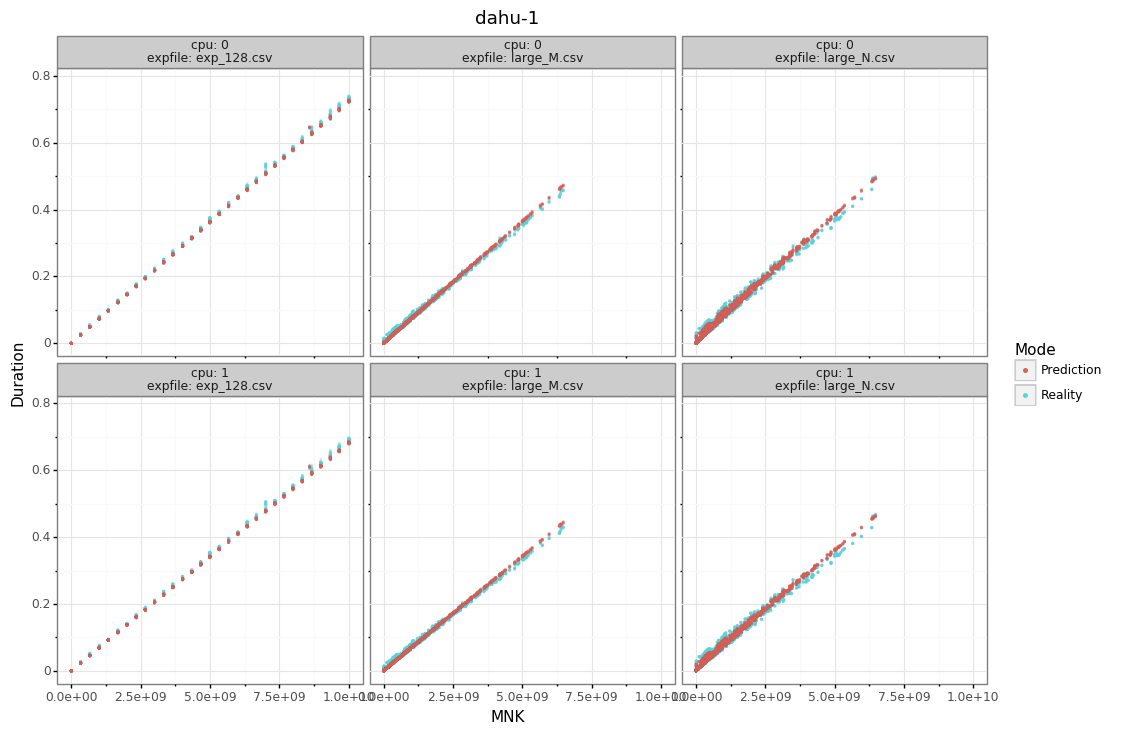

<ggplot: (-9223363294524454761)>


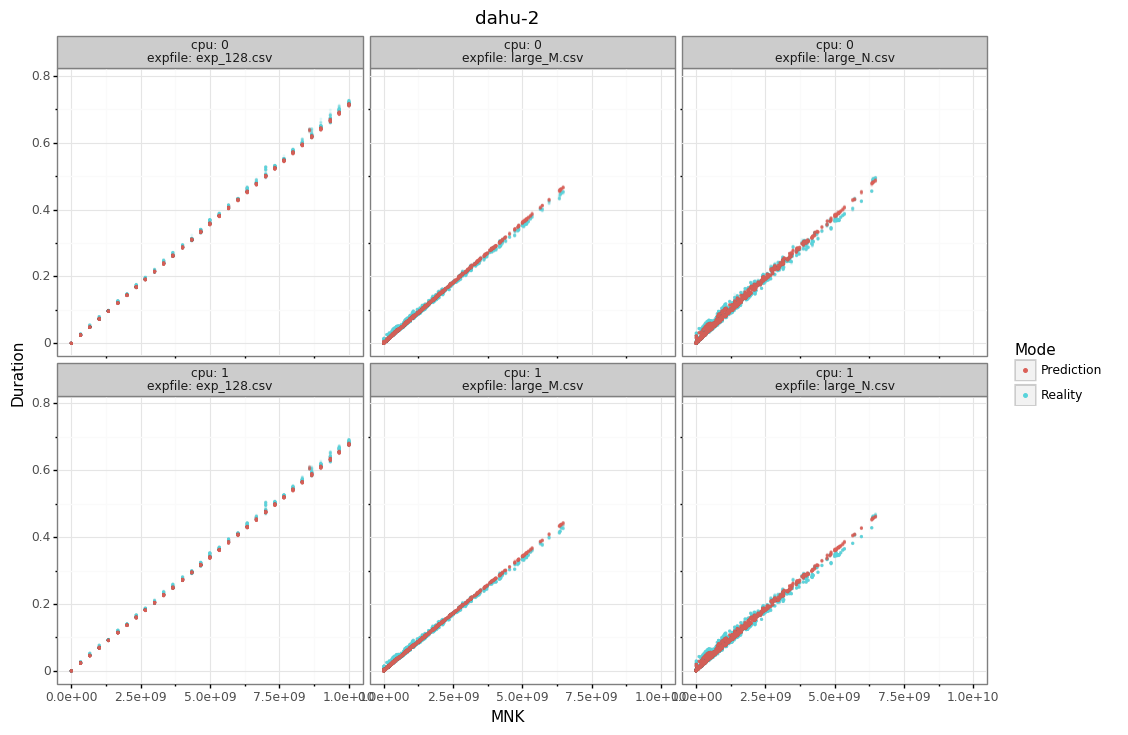

<ggplot: (-9223363294527462042)>


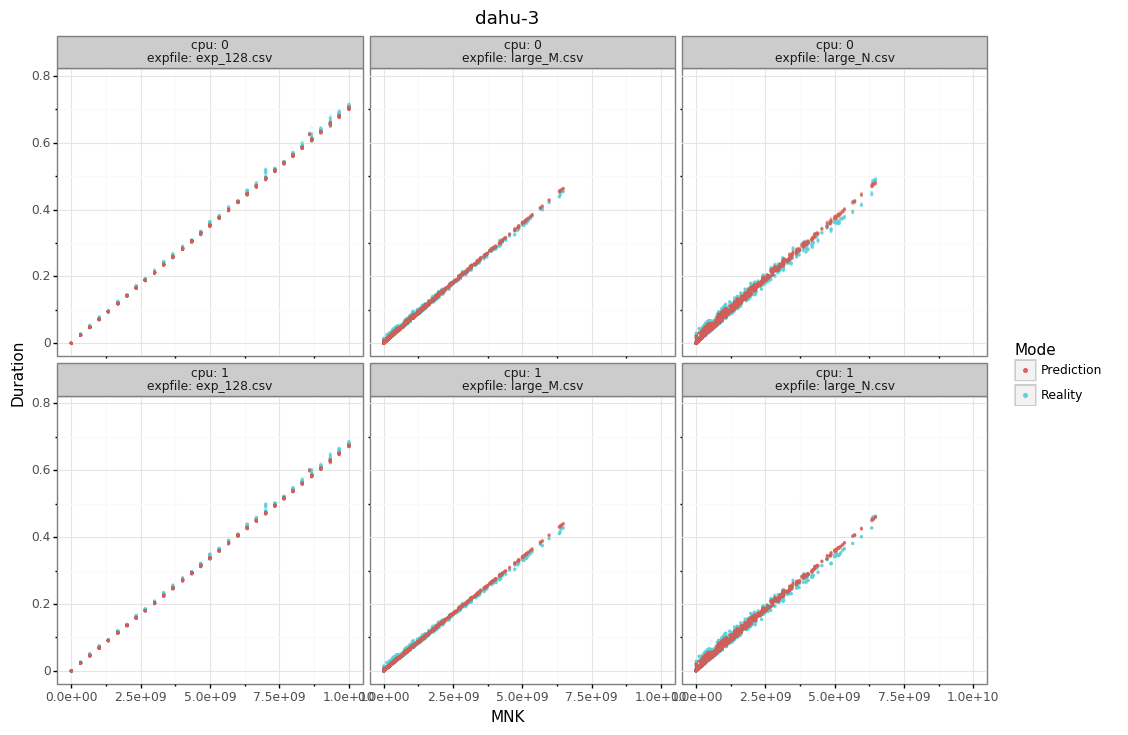

<ggplot: (-9223363294525541225)>


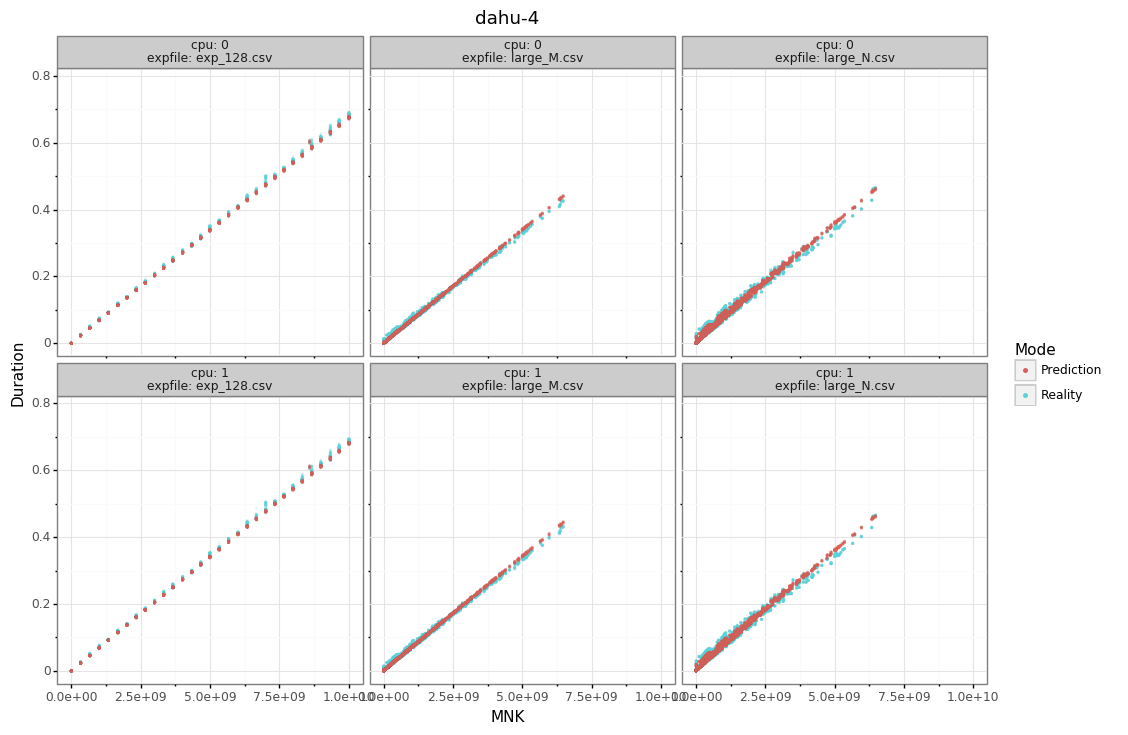

<ggplot: (8742327254420)>


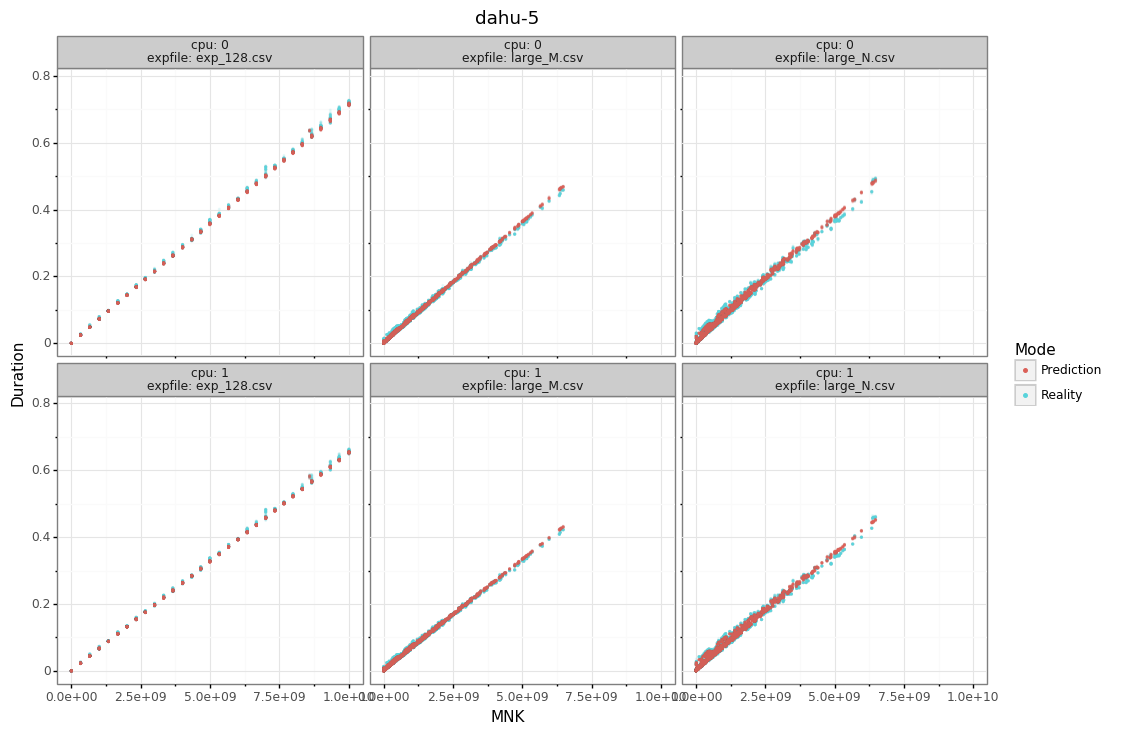

<ggplot: (8742317494995)>


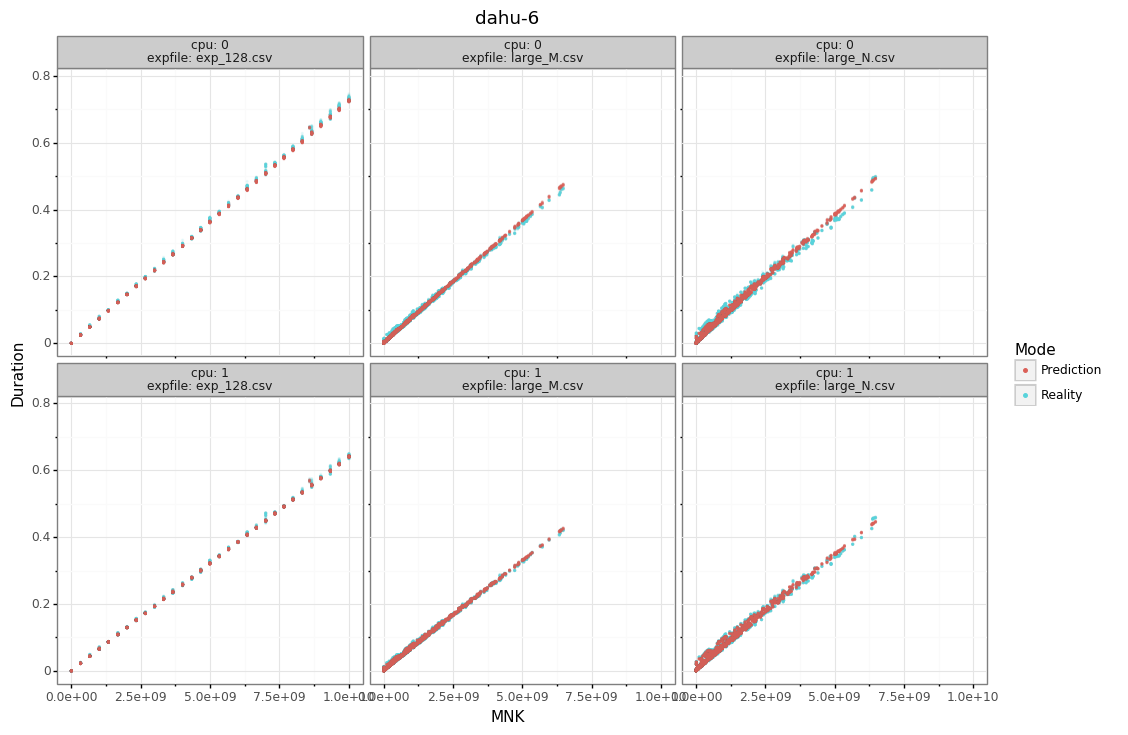

<ggplot: (8742329234496)>


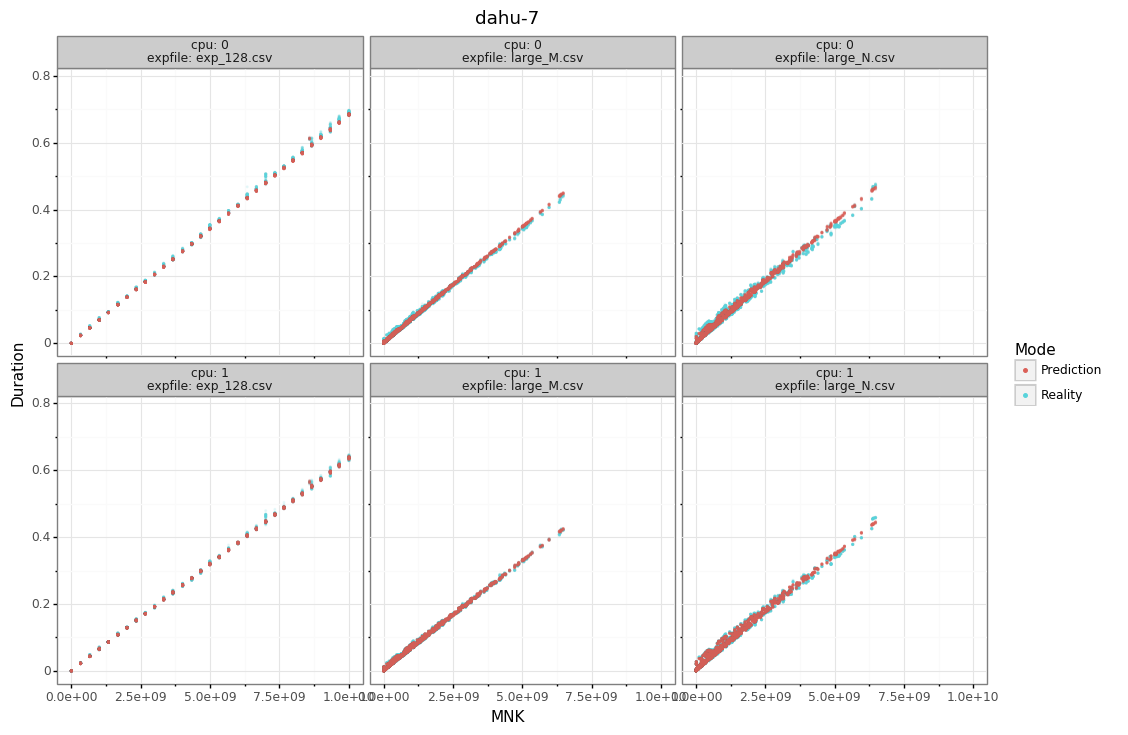

<ggplot: (-9223363294525734540)>


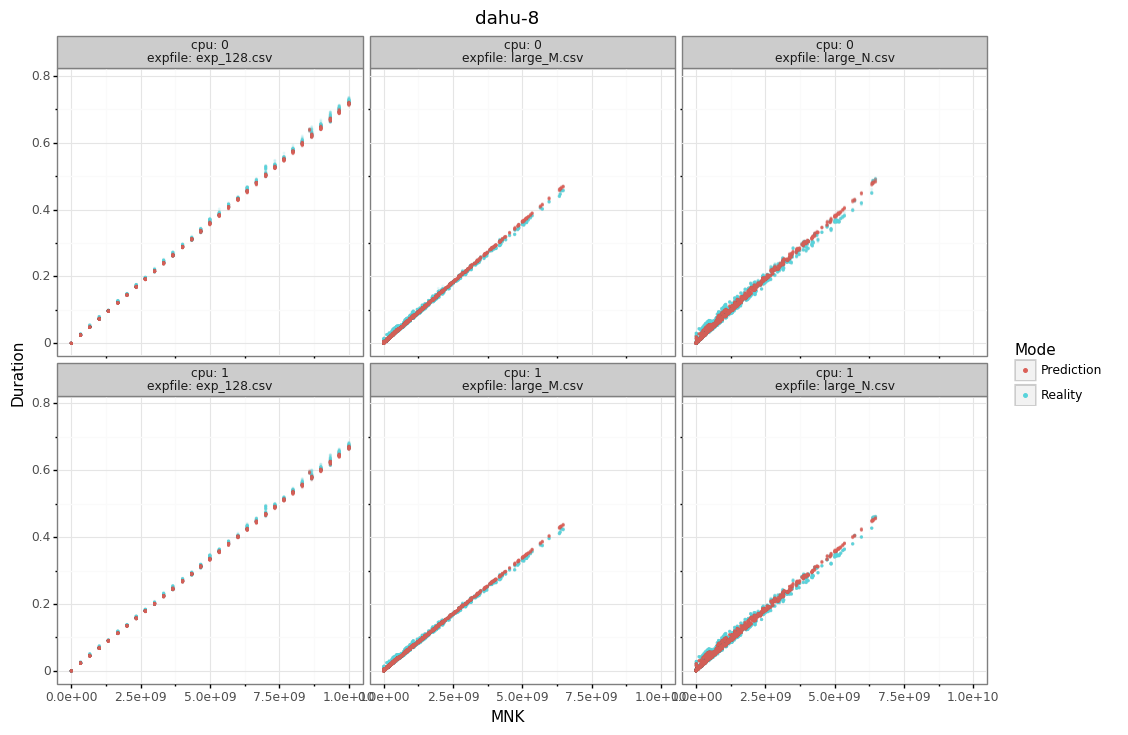

<ggplot: (-9223363294529222989)>


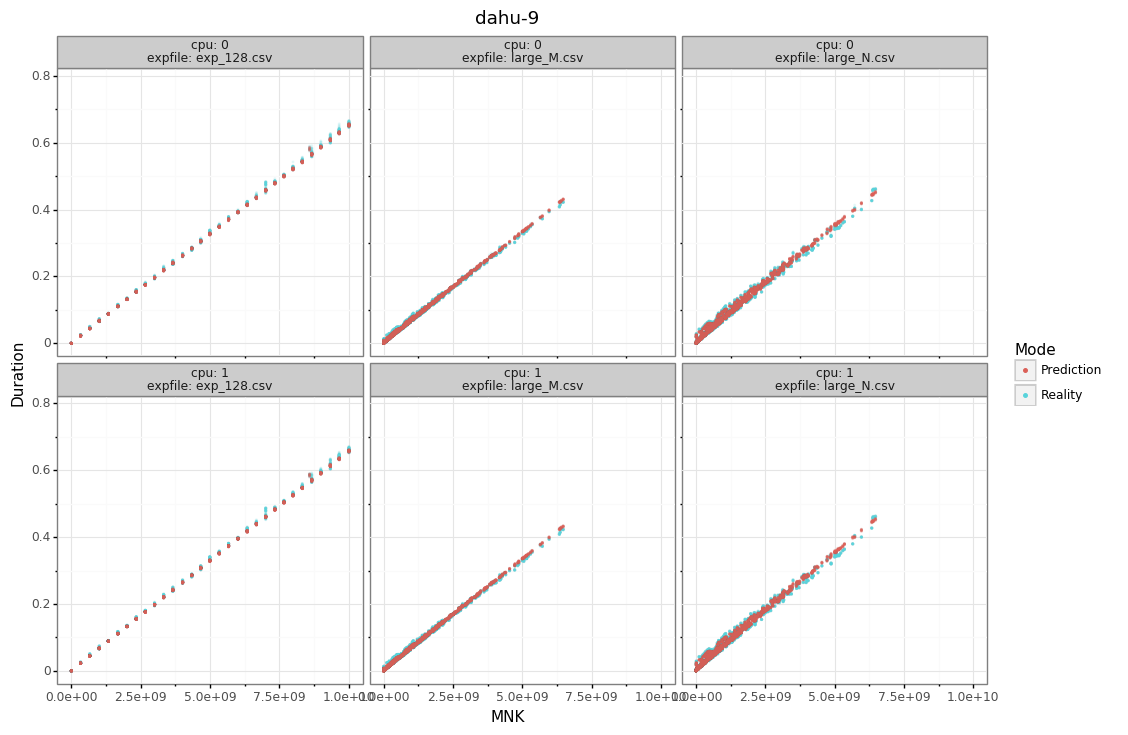

<ggplot: (8742317663394)>


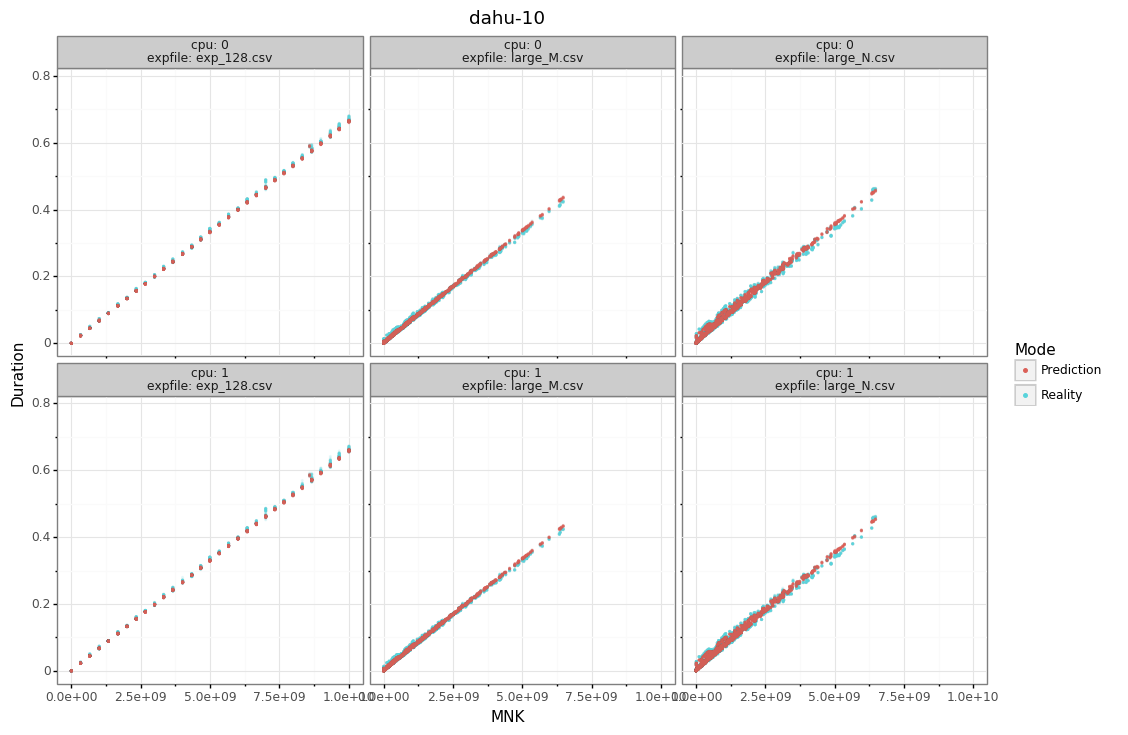

<ggplot: (-9223363294536438854)>


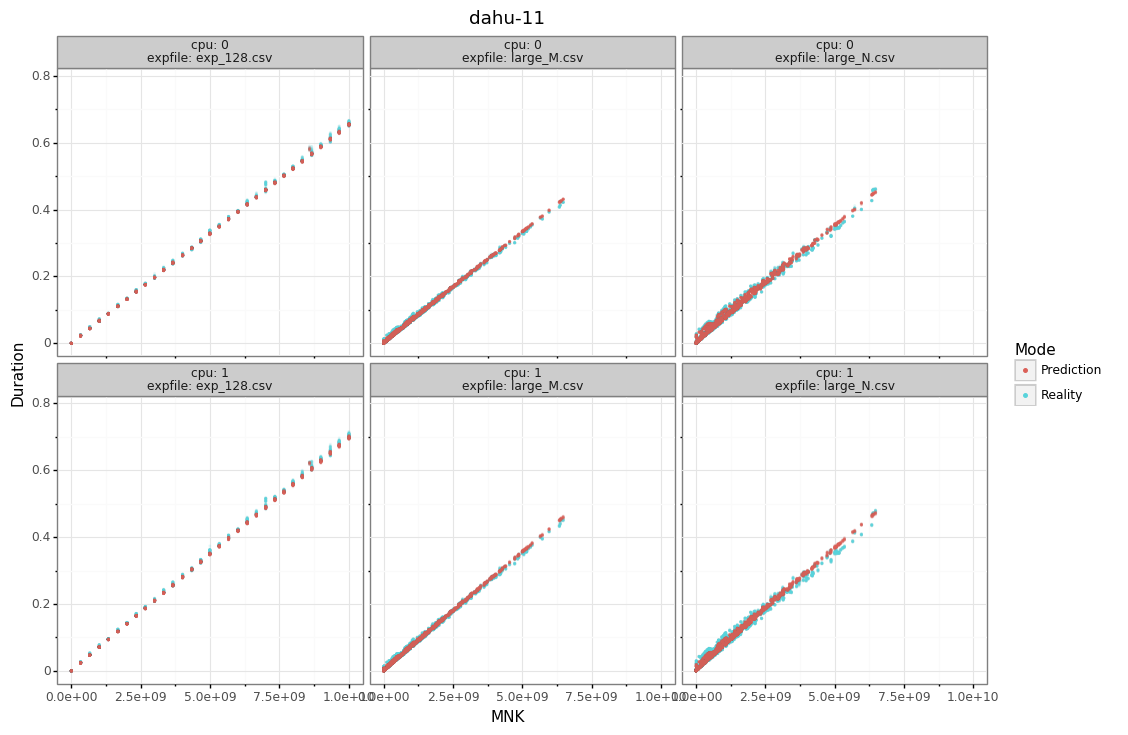

<ggplot: (-9223363294538575879)>


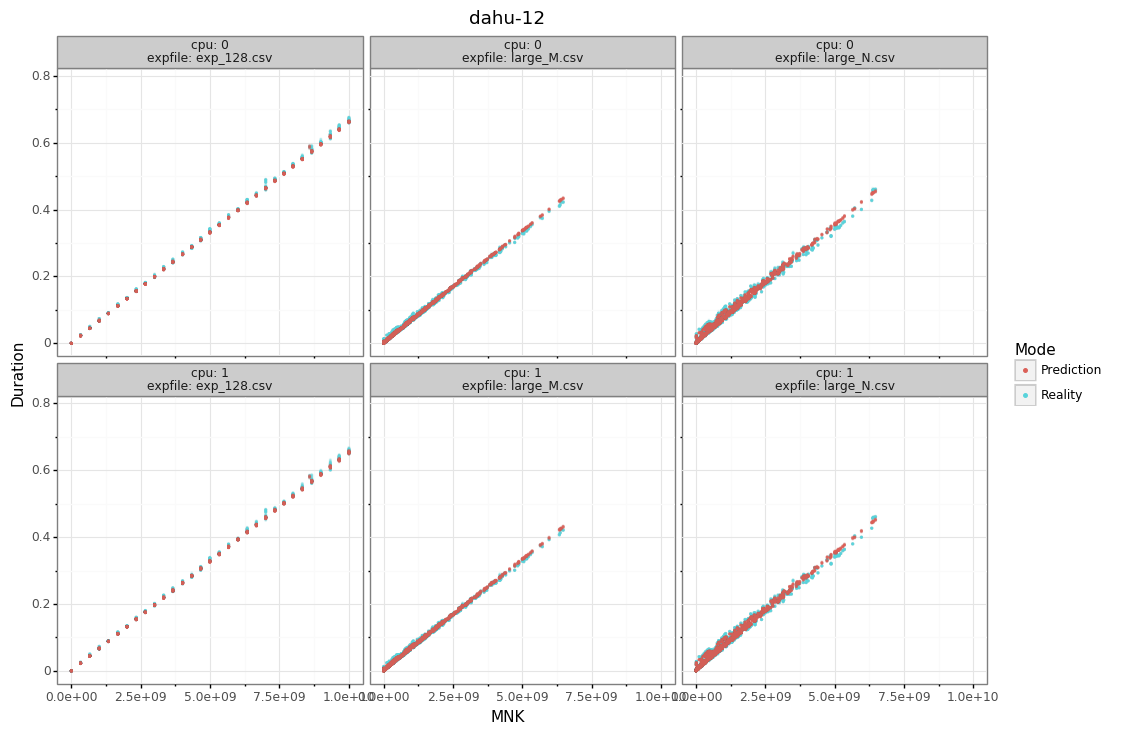

<ggplot: (8742326887649)>


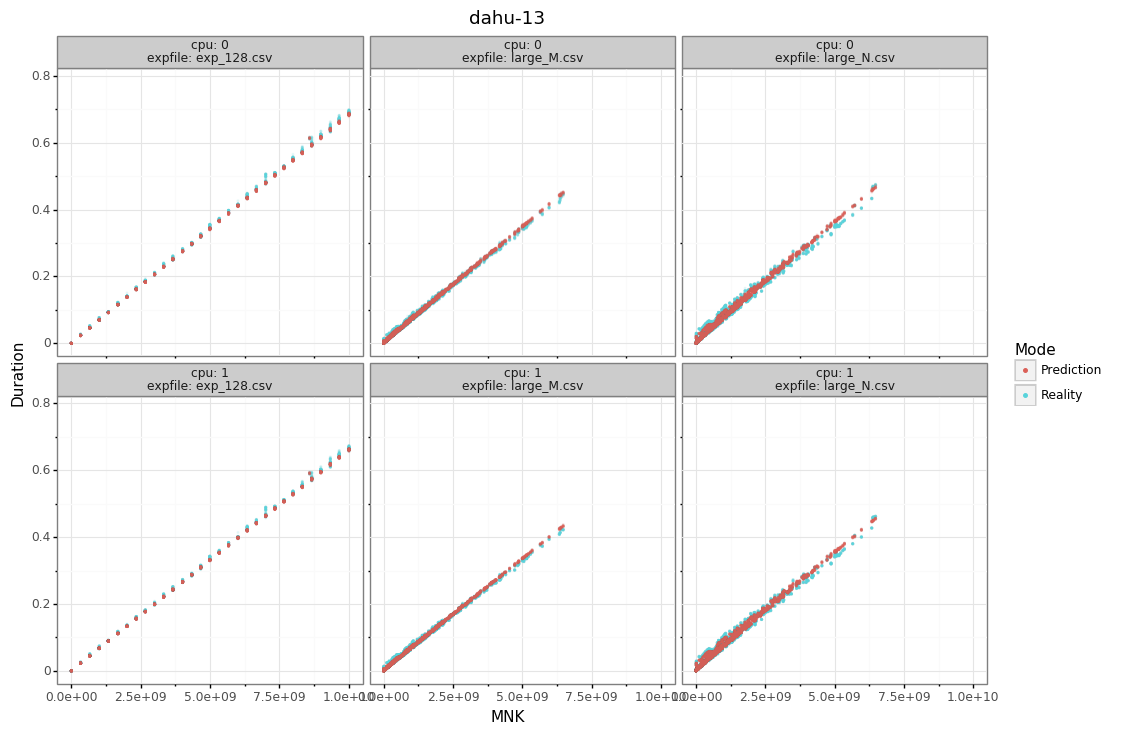

<ggplot: (-9223363294527487046)>


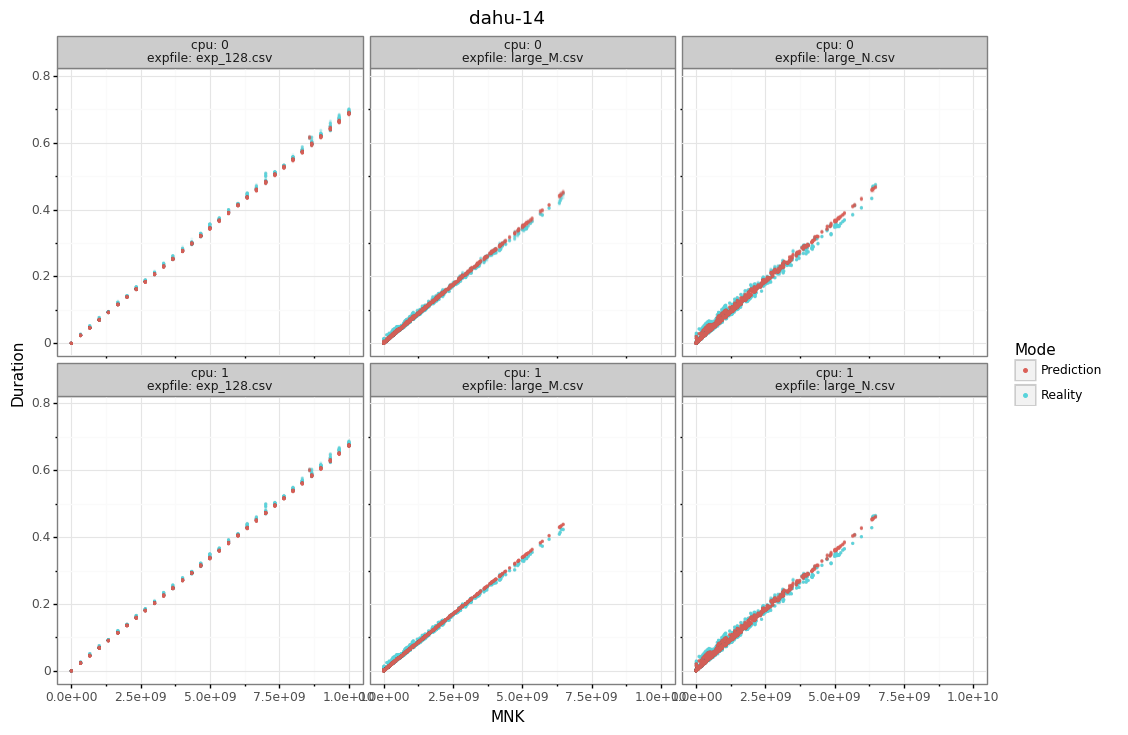

<ggplot: (-9223363294537932807)>


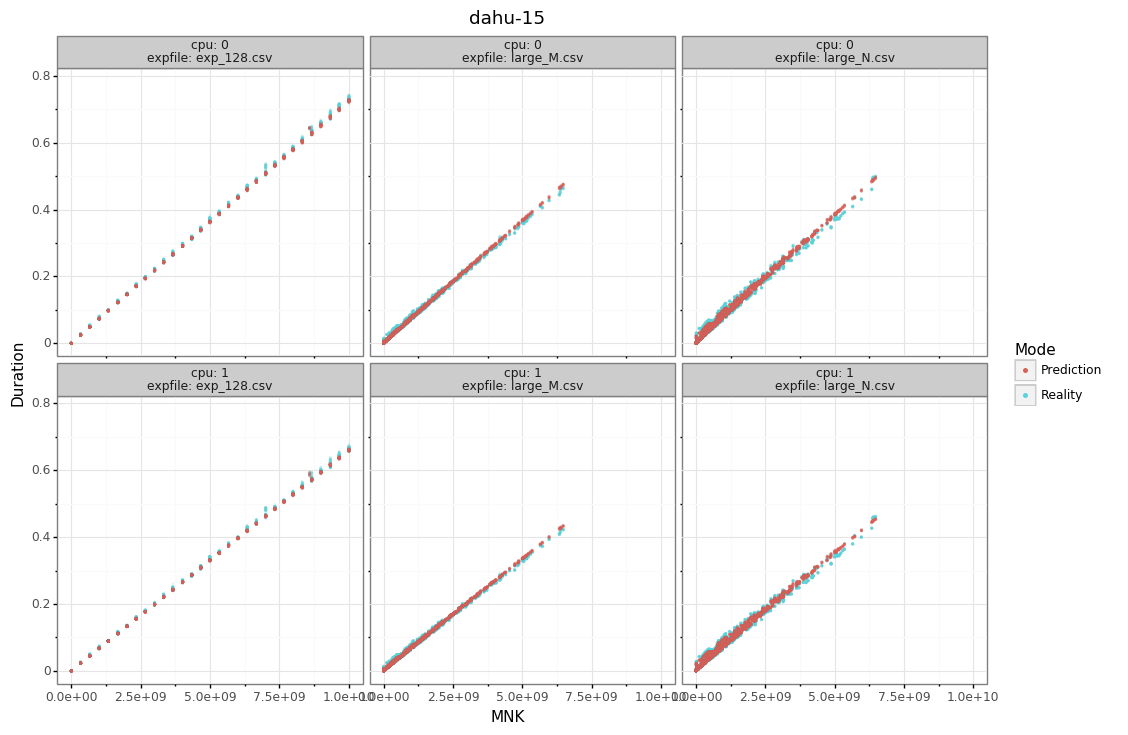

<ggplot: (8742317529187)>


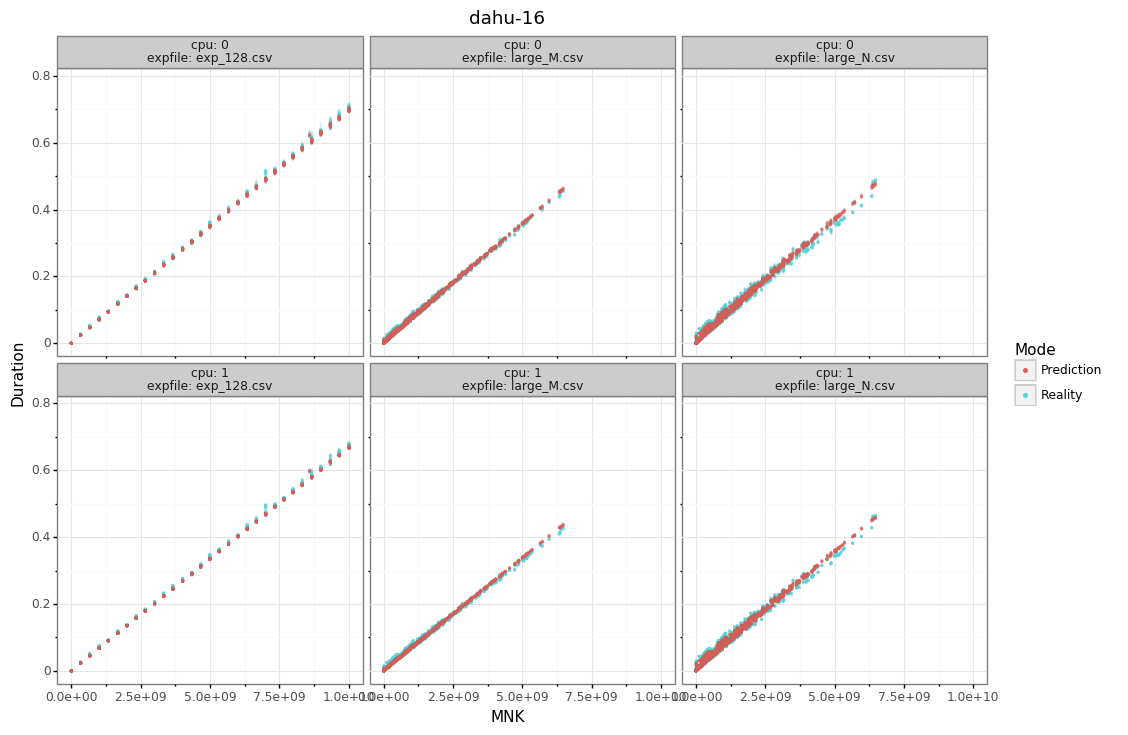

<ggplot: (-9223363294538473542)>


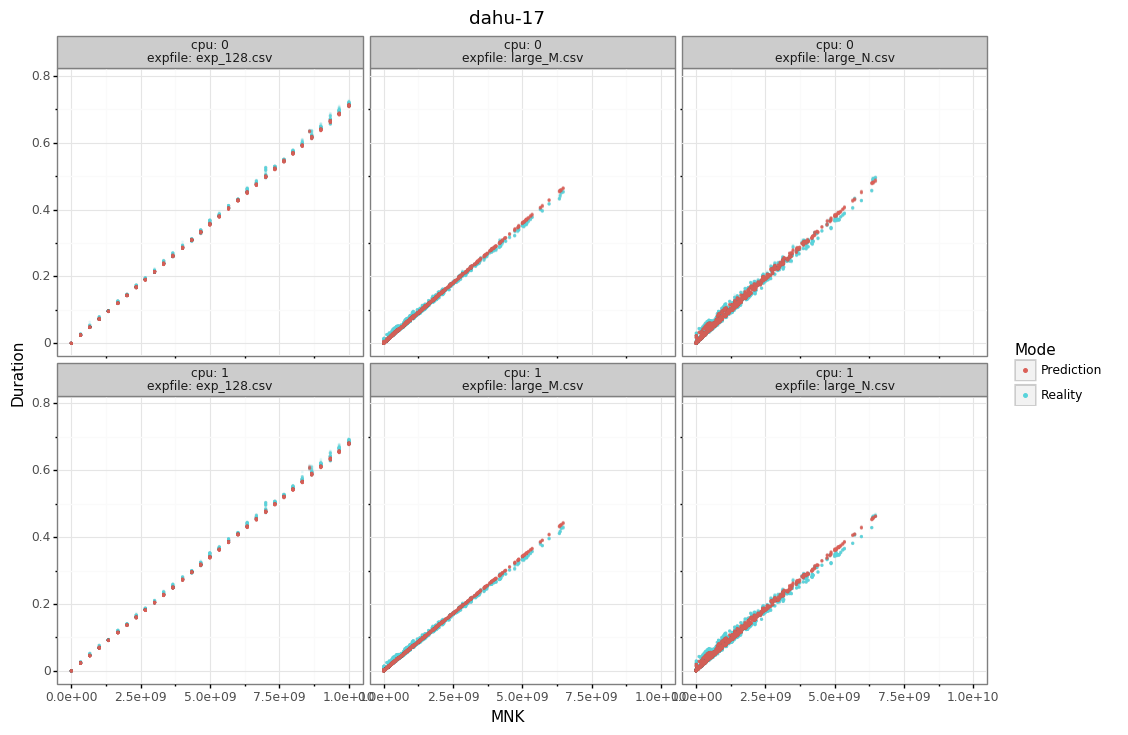

<ggplot: (-9223363294538457095)>


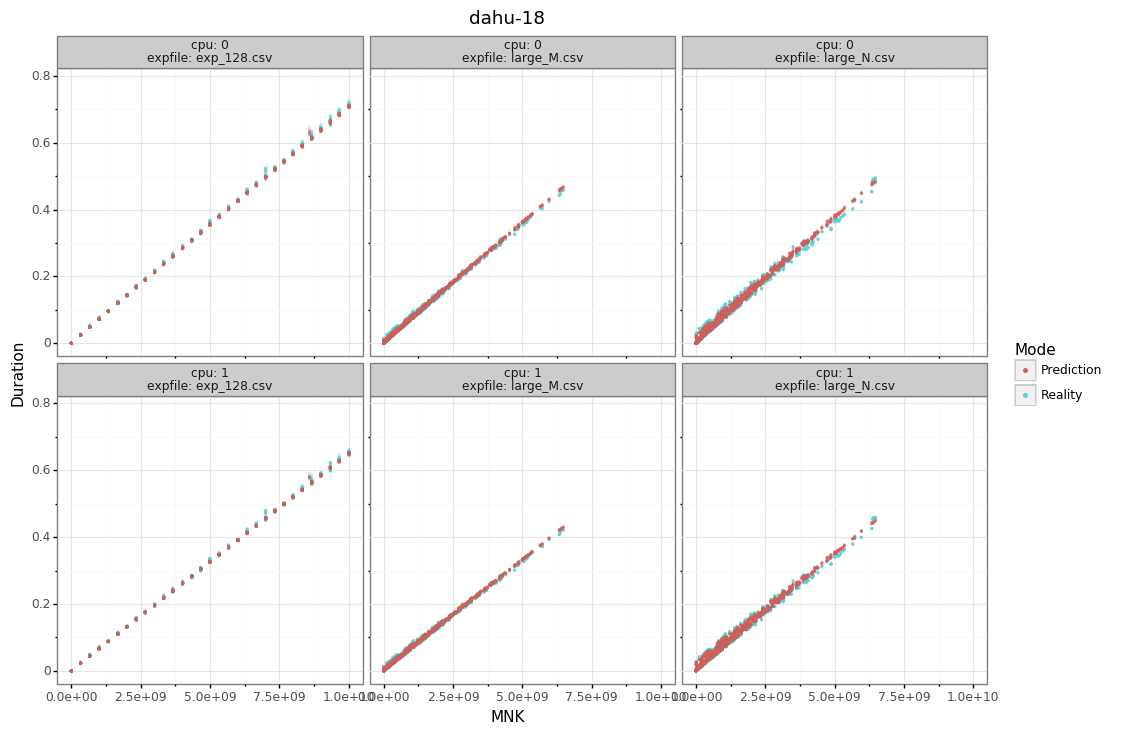

<ggplot: (-9223363294527493358)>


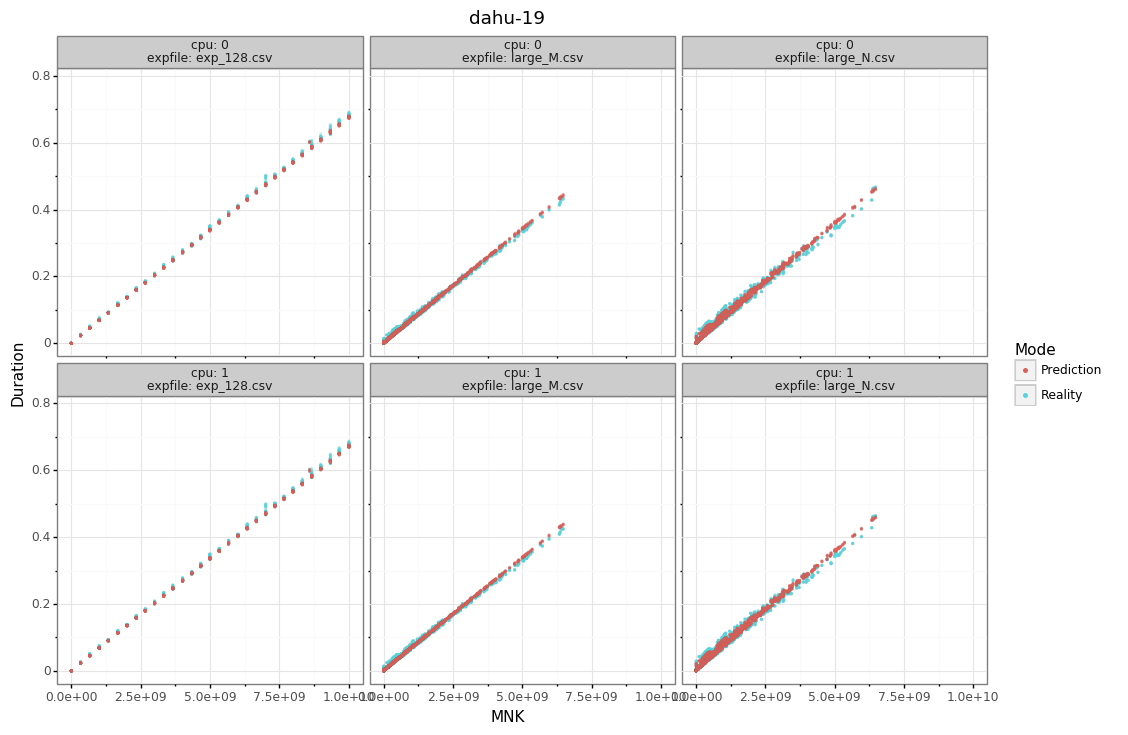

<ggplot: (-9223363294537091398)>


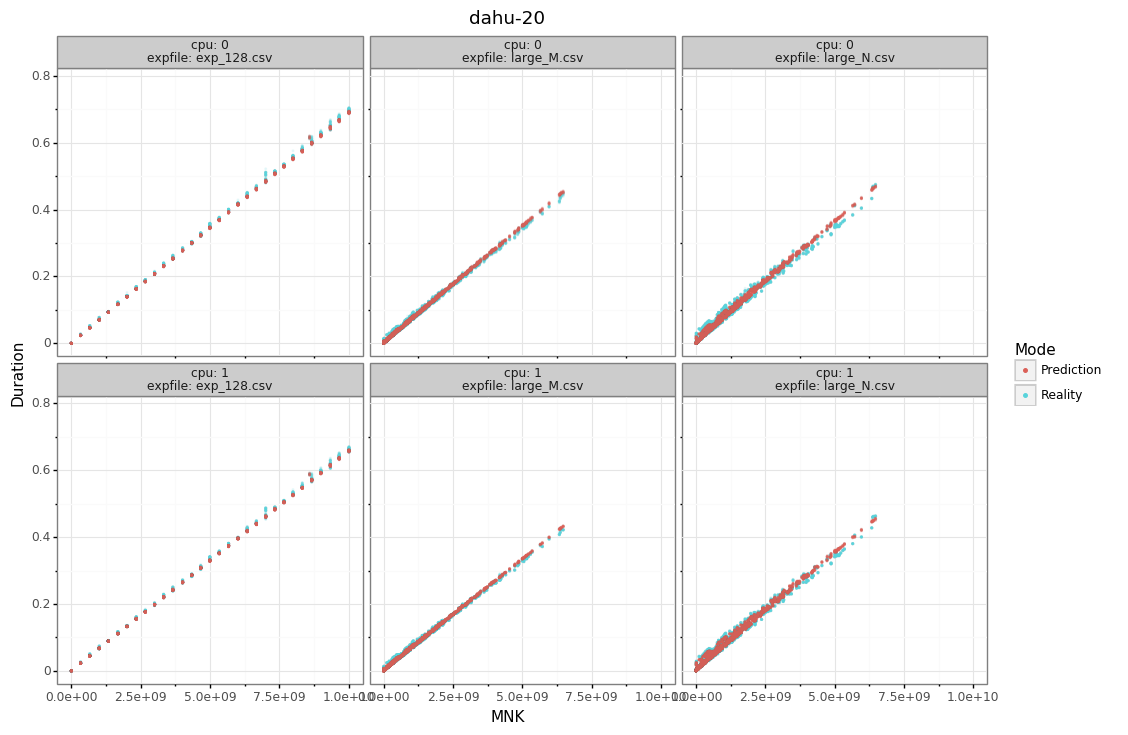

<ggplot: (-9223363294537800967)>


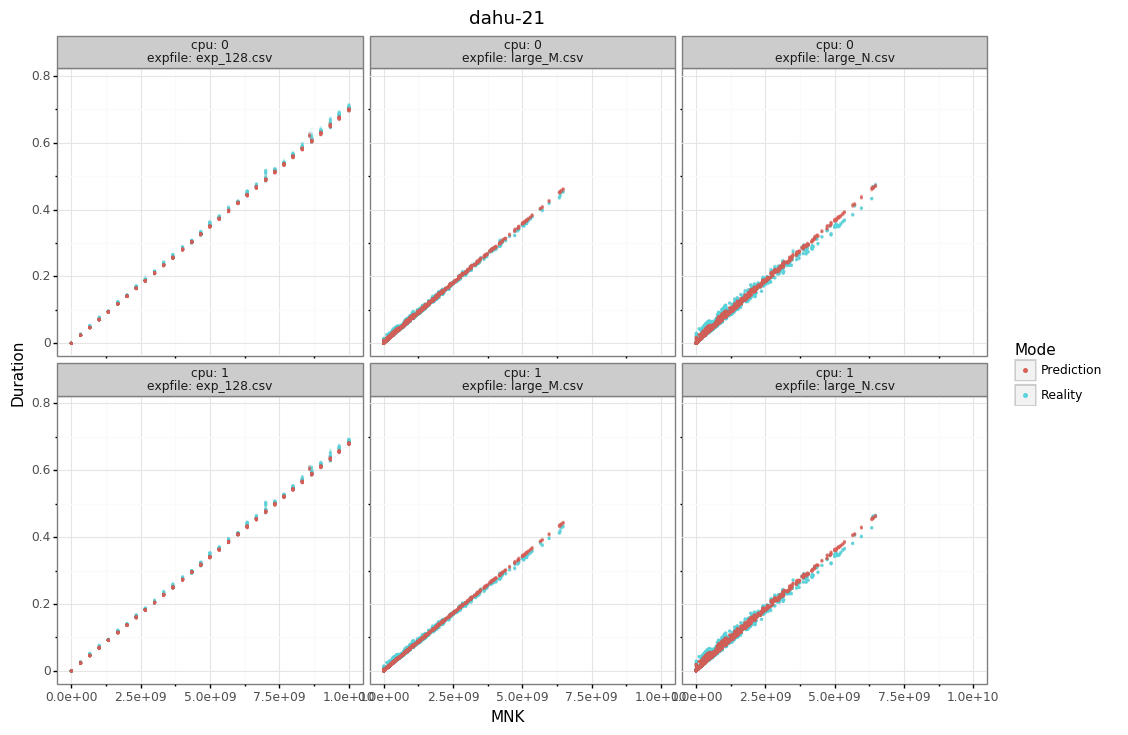

<ggplot: (8742317451247)>


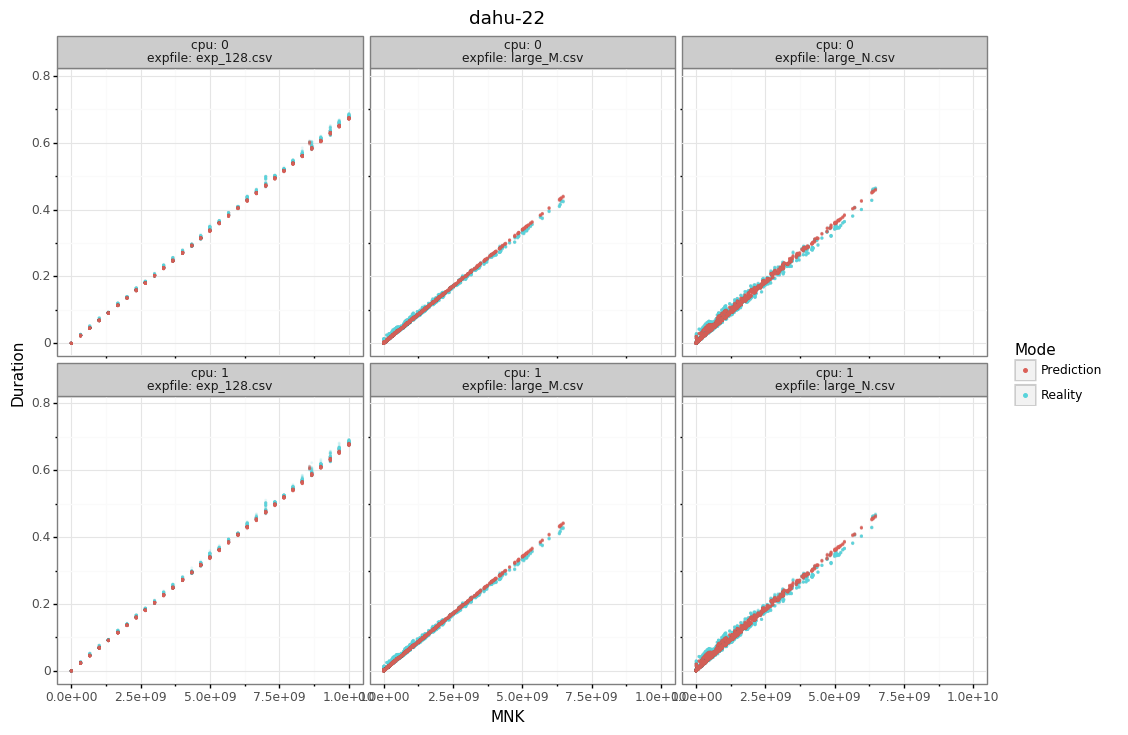

<ggplot: (-9223363294537662534)>


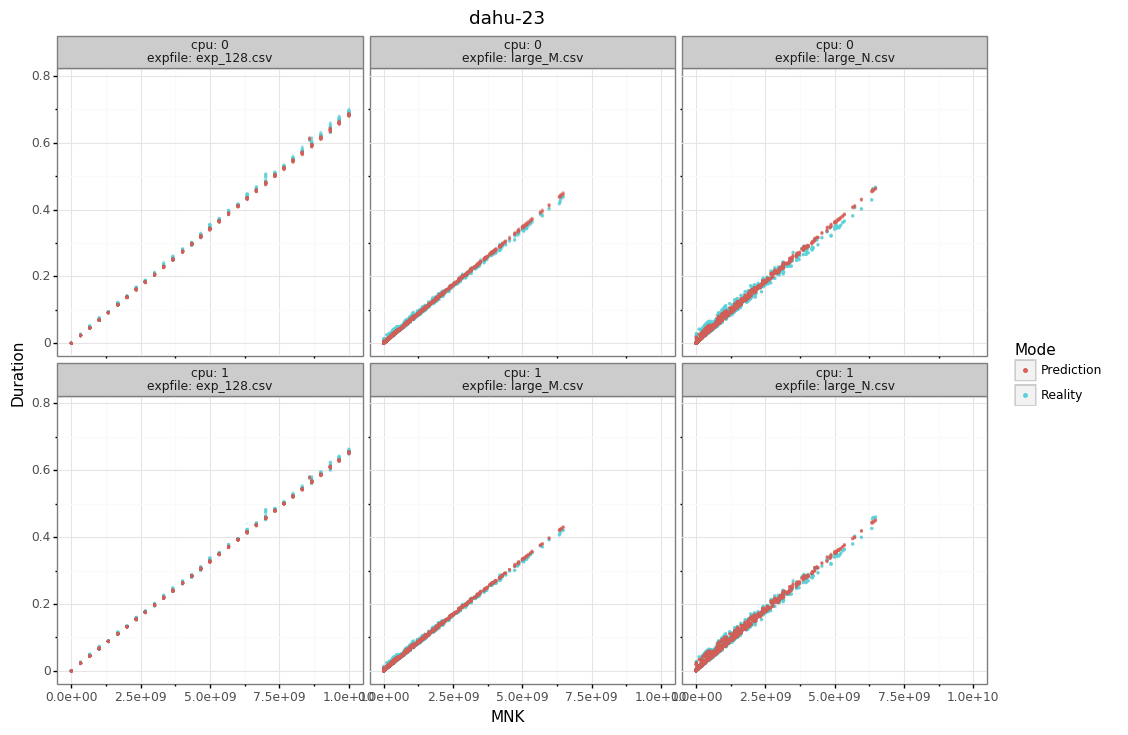

<ggplot: (-9223363294538226951)>


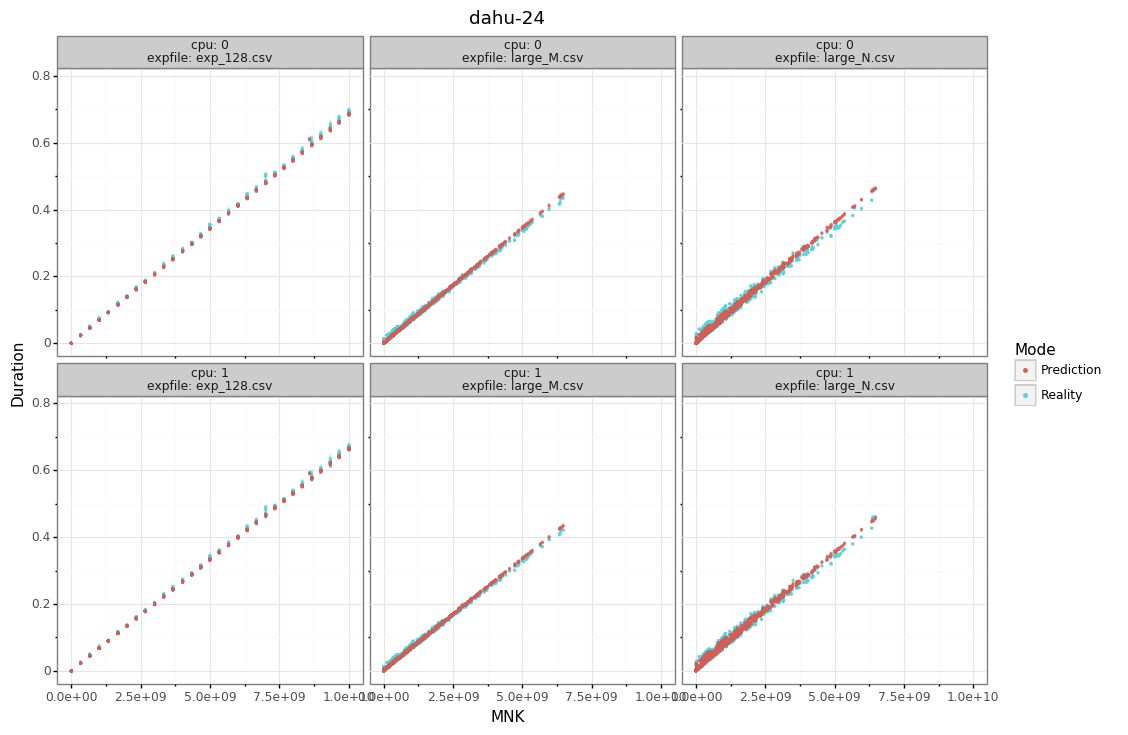

<ggplot: (8742317032936)>


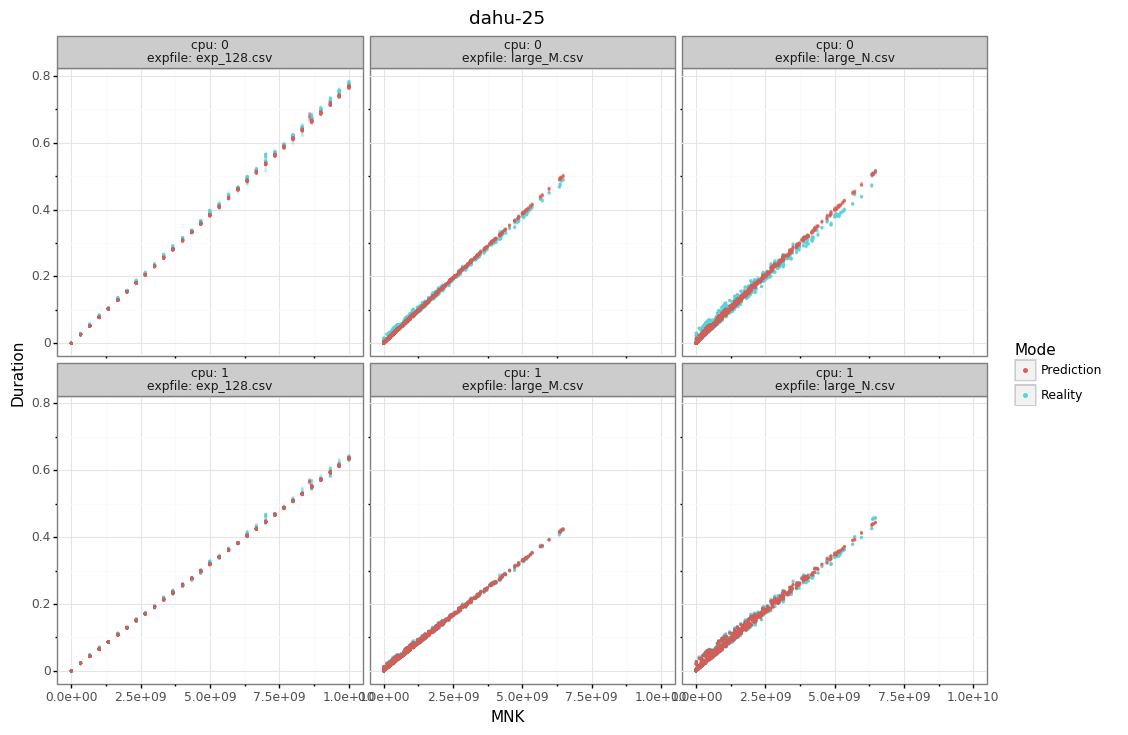

<ggplot: (-9223363294536769862)>


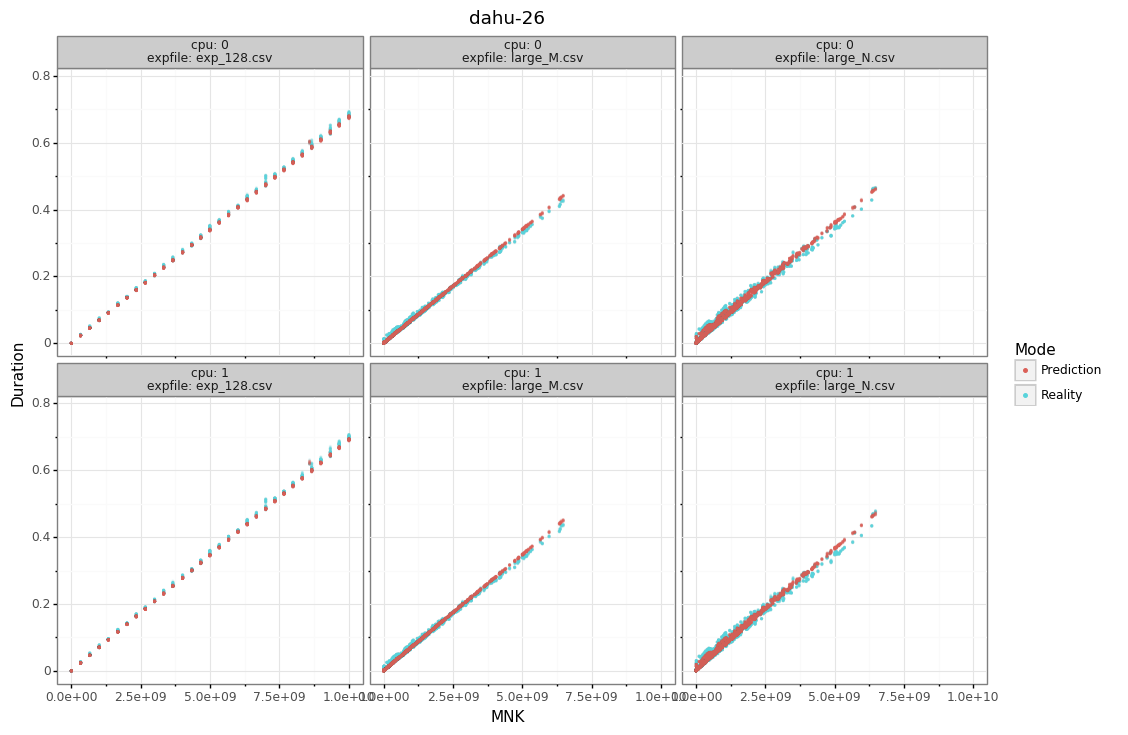

<ggplot: (-9223363294537214727)>


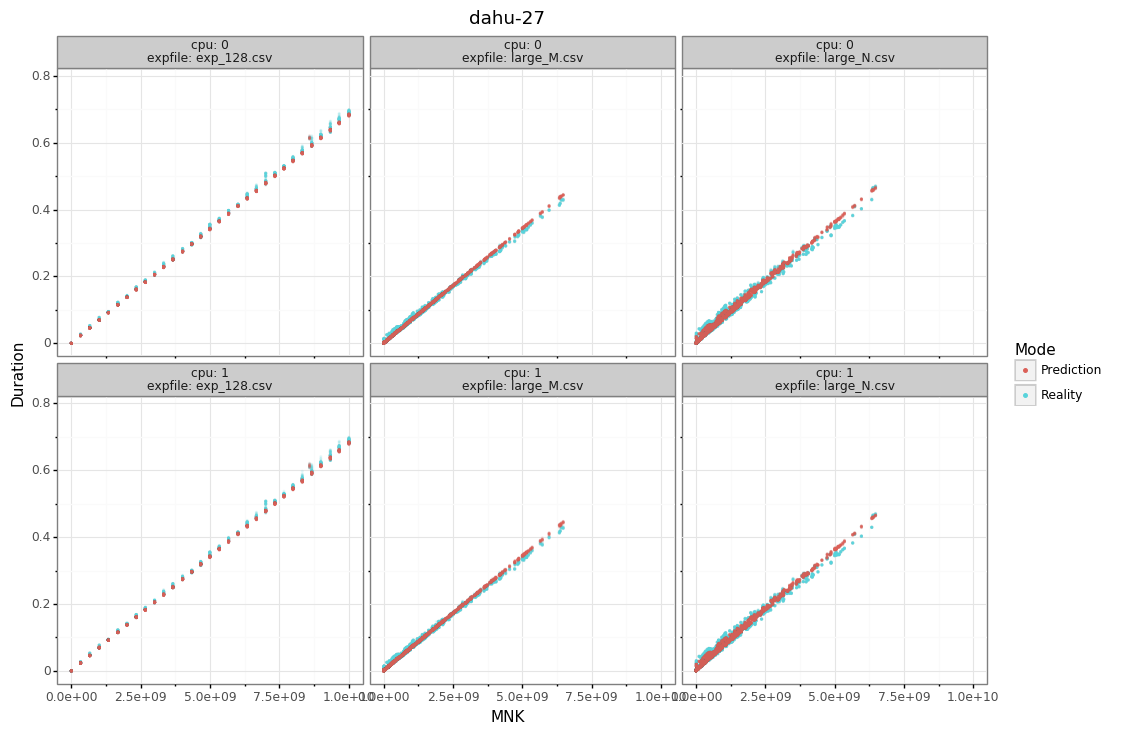

<ggplot: (8742316529903)>


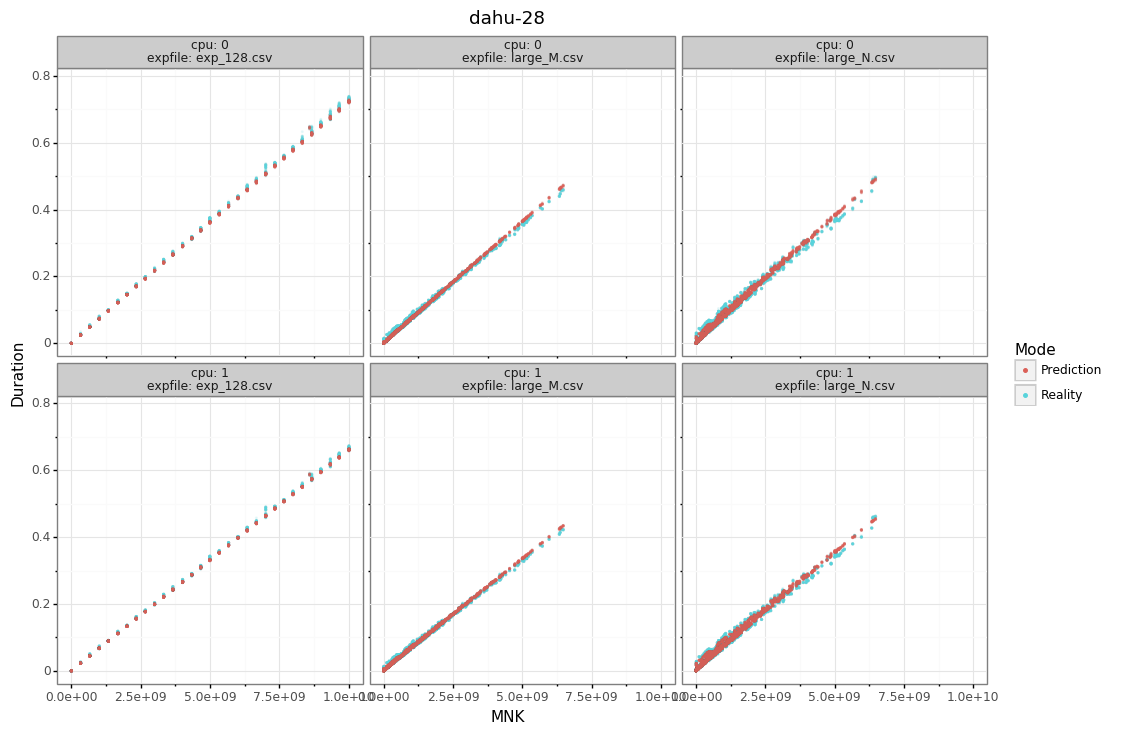

<ggplot: (-9223363294529145414)>


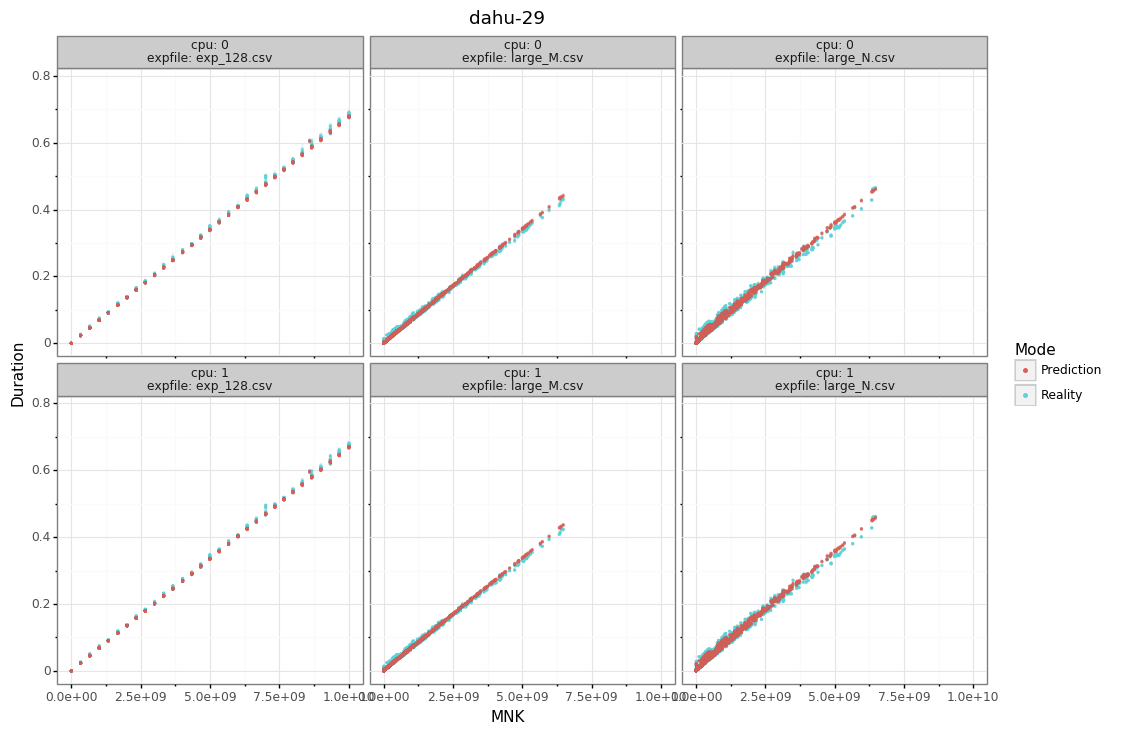

<ggplot: (-9223363294538180615)>


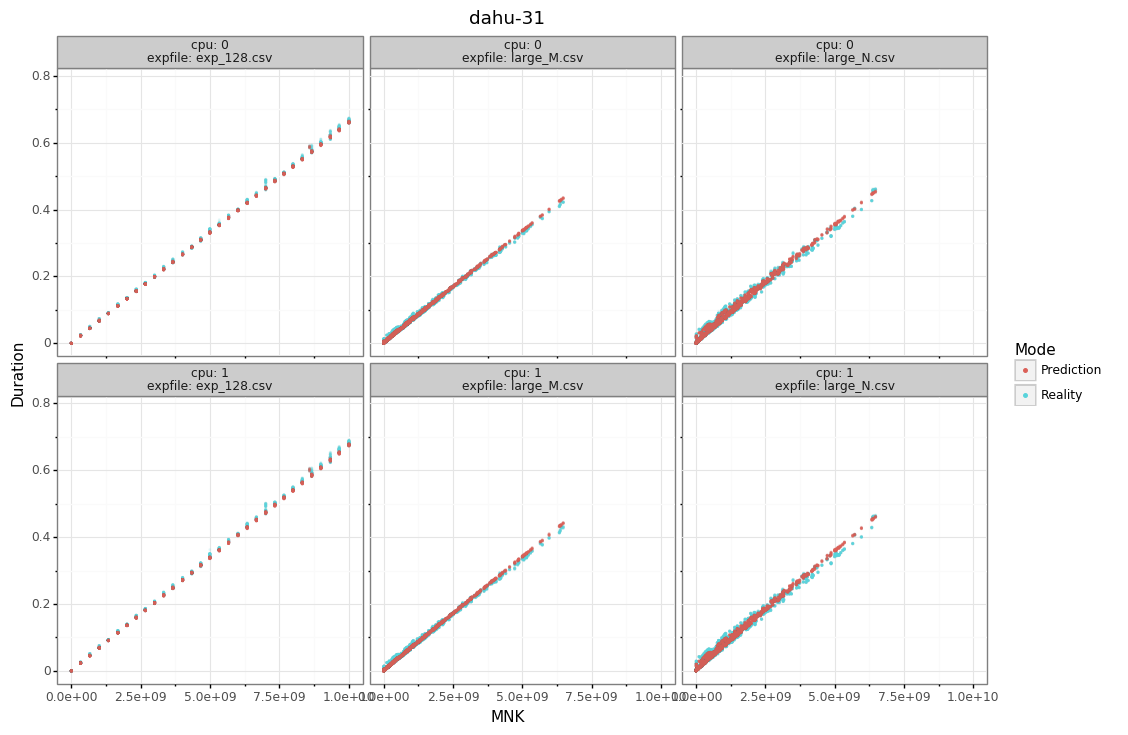

<ggplot: (-9223363294527841925)>


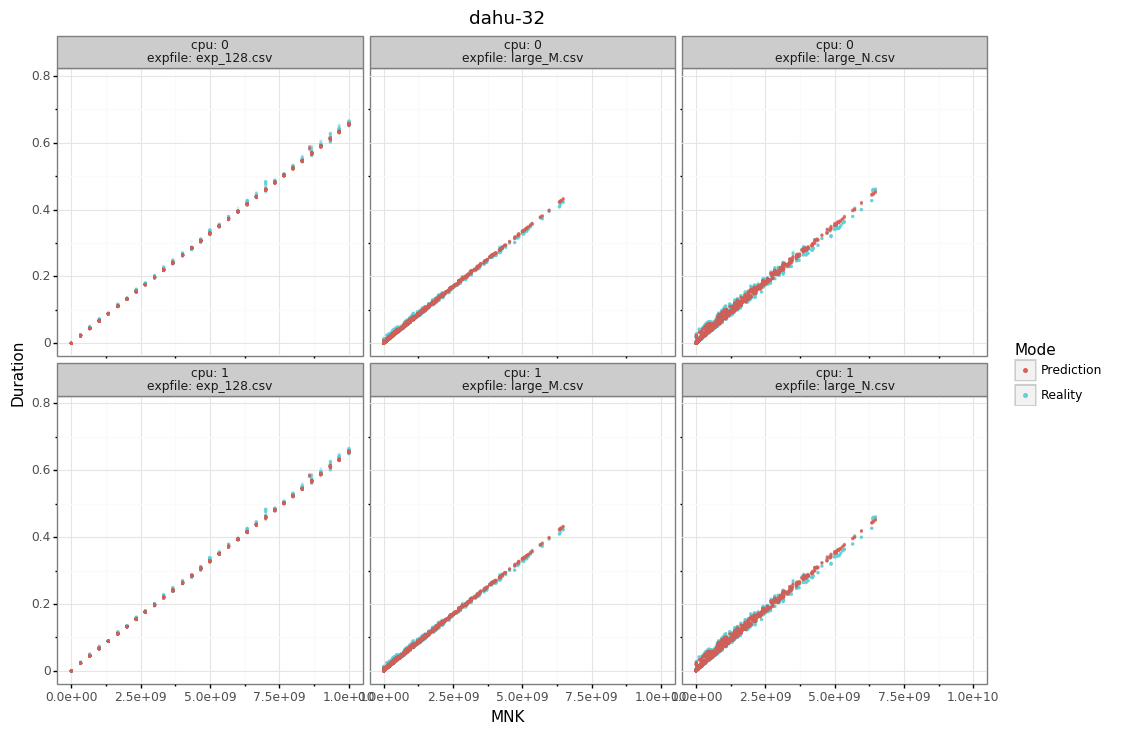

<ggplot: (-9223363294537867590)>


In [5]:
from mizani.formatters import scientific_format

max_y = prediction['value'].max()
for node in sorted(prediction.node.unique()):
    print(ggplot(prediction[prediction.node == node])
        + aes(x='mnk', y='value', color='variable')
        + geom_point(shape='.', size=1, alpha=0.1)
        + theme_bw()
        + labs(x='MNK', y='Duration', color='Mode')
        + scale_x_continuous(labels=scientific_format(digits=2))
        + scale_color_discrete(guide = guide_legend(override_aes=dict(alpha=1, shape='o')))
        + facet_wrap(['cpu', 'expfile'], labeller='label_both')
        + ggtitle(f'dahu-{node}')
        + expand_limits(y=max_y)
    )

### Dumping the model

The following code is adapted from the script [peanut/generate_model.py](https://github.com/Ezibenroc/peanut/blob/bd84822f3042270eaef9c4284179ee4e0ad22755/generate_model.py).

In [6]:
import datetime
import yaml
import copy

yaml_file = '/tmp/dgemm_generic_128.yaml'

def dump_reg(df, reg):
    reg = copy.deepcopy(reg)
    for tmp in reg:
        for key, val in tmp.items():
            if isinstance(val, (numpy.int, numpy.int64)):
                tmp[key] = int(tmp[key])
            elif isinstance(val, (numpy.float, numpy.float64)):
                tmp[key] = float(tmp[key])
    result = {'info': {}}
    for key in ['cluster', 'function']:
        values = {tmp[key] for tmp in reg}
        assert len(values) == 1
        result['info'][key] = values.pop()
        for tmp in reg:
            del tmp[key]
    for key in['jobid', 'expfile_hash', 'start_time']:
        values = list(df[key].unique())
        if key == 'jobid':
            values = [int(v) for v in values]
        else:
            values = [str(v) for v in values]
        result['info'][key] = values
        for tmp in reg:
            del tmp[key]
    result['info']['experiment_date'] = result['info']['start_time']
    del result['info']['start_time']
    avg_alpha = numpy.mean([tmp['mnk'] for tmp in reg])
    avg_beta  = numpy.mean([tmp['intercept'] for tmp in reg])
    var_coeff = numpy.mean([tmp['mnk_residual']/tmp['mnk'] for tmp in reg])
    het_coeff = numpy.std([tmp['mnk'] for tmp in reg]) / avg_alpha
    result['info'].update({
        'avg_gflops': float(2e-9/avg_alpha),
        'avg_latency': float(avg_beta),
        'heterogeneity_coefficient': float(het_coeff),
        'variability_coefficient': float(var_coeff),
        'nb_nodes': len(df['node'].unique()),
    })
    for tmp in reg:
        tmp['cpu_id'] = 2*tmp['node'] + tmp['cpu']  # see the function get_cpuid() in HPL_dgemm.c
    result['model'] = reg
    result['metadata'] = {
        'file_creation_date': str(datetime.datetime.now()),
        'archive_file': list(df['archive'].unique()),
        'cashew_git': cashew.__git_version__,
        'granularity': 'cpu',
    }
    return result

with open(yaml_file, 'w') as f:
    yaml.dump(dump_reg(df, reg_dict), f)

In [7]:
!sha256sum $yaml_file
!wc -l $yaml_file
!echo
!head -n 28 $yaml_file

163aa21d41074673d6f6eaa22510d0f574ea46d8e1fa6316cf6000b9604037e7  /tmp/dgemm_generic_128.yaml
1393 /tmp/dgemm_generic_128.yaml

info:
  avg_gflops: 28.927805769083317
  avg_latency: 2.5739354838709672e-06
  cluster: dahu
  experiment_date:
  - '2020-07-08T06:25:34.000000000'
  - '2020-07-08T06:51:56.000000000'
  - '2020-07-08T07:17:02.000000000'
  expfile_hash:
  - 7182bdc09785b7b57fa9065f096c0774467e68b7da37e920868663865b6f4242
  - 534e87a021d988bd1f50ee1b4aa15065b1fc465bde5df2e29ad6d83878d59e48
  - 08090da5c4cb27c6e3b81112ddea75febf3ca40f342fb5d8f61ad55a6a82f69a
  function: dgemm
  heterogeneity_coefficient: 0.03970299378614987
  jobid:
  - 1939567
  - 1939568
  - 1939569
  nb_nodes: 31
  variability_coefficient: 0.003908670519883098
metadata:
  archive_file:
  - geometry/1/grenoble_2020-07-08_1939567.zip
  - geometry/1/grenoble_2020-07-08_1939568.zip
  - geometry/1/grenoble_2020-07-08_1939569.zip
  cashew_git: f6e1abe82ebba1eec668652189985c631c10b5b5
  file_creation_date: '2020-07-0